# Model fitting. Determine Teff and log(g).

In [1]:
import sys
sys.path.append('/mnt/c/Users/luukv/Documenten/NatuurSterrkenkundeMasterProject/CodeMP/MasterProject')

import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.interpolate import CubicSpline
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Iterable

from import_data import BailerJones
from model_functions import *
from functions import import_spectra, extract_spectrum_within_range

Import models and spectrum (~21 seconds)

In [2]:
# Import models for given galaxy
models = import_models_quickload('Milkyway')
# Import spectrum of given object
spectra = import_spectra('4U1700_37')

# Name of object
object_name = '4U1700-37'
# Distance to object
distance = BailerJones().loc[BailerJones().id == object_name]['r_med_photogeo'].reset_index(drop=True).at[0]
# Vsin(i) of object
vsini_best = 170

In [3]:
def select_spectrum(spectra: list, central_wav: float)->tuple:
    """
    Select the spectrum containing the given spectral line

    Args:
        spectra (list): List of spectra, made by import_spectra(object)
        central_wav (float): Central wavelenght of the spectral line

    Returns:
        tuple: wavelength, flux
    """
    for spectrum in spectra[::-1]:
        if central_wav >= min(spectrum[0])  and central_wav <= max(spectrum[0]):
            return spectrum[0], spectrum[1]



def select_SNR(wav:list, SNR:list)->float:
    """
    Select the SNR that corresponds to the spectrum

    Args:
        wav (list): Wavelength of the spectrum
        SNR (list): List with SNR of all spectra

    Returns:
        float: SNR
    """
    for i in SNR:
        if i[0] >= min(wav) and i[0] <= max(wav):
            return i[1]



def extract_continuum(wavelengths: np.array, flux: np.array, start: float, end: float, line_left: float, line_right: float)->tuple:
    """
    Extract continuum from spectrum

    Args:
        wavelengths (np.array): List with wavelength
        flux (np.array): List with flux
        start (float): Start of spectrum
        end (float): End of spectrum
        line_left (float): Start spectral line
        line_right (float): End spectral line

    Returns:
        tuple: (Wavelength, Flux)
    """
    # Find indices corresponding to the specified wavelength range
    indices_left = np.where((wavelengths >= start) & (wavelengths <= line_left))[0]
    indices_right = np.where((wavelengths >= line_right) & (wavelengths <= end))[0]
    indices = np.concatenate((indices_left, indices_right))

    # Extract wavelength and flux values within the range
    extracted_wavelengths = wavelengths[indices]
    extracted_flux = flux[indices]

    return extracted_wavelengths, extracted_flux

In [4]:
def chi_squared(wav_model, flux_model, wav_line, flux_line, SNR):

    # Get the flux for every wavelenght of the data.
    # Create a CubicSpline object
    cubic_spline = CubicSpline(wav_model, flux_model)

    # Interpolate intensity at the desired wavelengths
    flux_model_inter = cubic_spline(wav_line)

    # Calculate chi-squared
    chi_squared = 0
    for i in range(len(flux_line)):
        chi_squared += ( (flux_model_inter[i] - flux_line[i]) / (1 / SNR) ) ** 2
    chi_squared /= len(wav_line)

    return chi_squared

In [5]:
def gaussian(x: list, mean: float, amplitude: float, stddev: float, continuum: float)->list:
    """
    Gauss

    Args:
        x (list): Data
        mean (float): mu
        amplitude (float): amplitude
        stddev (float): sigma
        continuum (float): c parameter

    Returns:
        list: y-values of gauss
    """
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2) + continuum

In [6]:
def determine_doppler_shift(spectra: list, lines: dict, guassian: callable, plot: bool=False)->list:
    """
    This function takes a spectra and list with lines (and their ranges)
    and fits a gaussian to these lines to determine the doppler shift of
    the spectrum.

    Args:
        spectra (list): Spectra of the object (UVES)
        lines (dict): Spectral lines and their ranges
        guassian (callable): Function of a gaussian
        plot (bool, optional): If true, the fits to the data are shown. Defaults to False.

    Returns:
        list: All doppler shift of the individual lines.
    """
    ## FIT ALL LINES
    # Dictionary to save the fit results.
    fit_results = {}

    # Fit a gauss to all spectral lines
    for line in lines['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        # Initial guess for the parameters
        initial_guess = [line[0] - lines['Doppler_guess'], # mu
                         max(flux_line) - np.mean(flux_cont), # amplitude
                        (max(wav_line) - min(wav_line)) / 3.5, # stddev
                        np.mean(flux_cont)] # continuum height

        # Fit the data
        params, covariance = curve_fit(gaussian, wav, flux, p0=initial_guess)

        # Save results
        fit_results[line[1]] = {"spectrum": (wav, flux),
                                "continuum": (wav_cont, flux_cont),
                                "line": (wav_line, flux_line),
                                "fit_result": (params, covariance),
                                "rest_wavelength": line[0]}


    ## DETERMINE THE DOPPLER SHIFT
    # Calculate the dopplershift for every line
    doppler_shift = []
    for line, data in fit_results.items():
        lambda0 = data['rest_wavelength']
        delta_lambda = data['fit_result'][0][0] - lambda0
        velocity = delta_lambda / lambda0 * 3E5 # km/s
        doppler_shift.append(velocity)

    print(doppler_shift)
    print(f'The velocity of the object is: {np.mean(doppler_shift)} +- {np.std(doppler_shift)}')


    ## PLOT THE FIT RESULTS
    if plot:
        num_plots = len(fit_results)
        num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed

        fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

        # Flatten axes if necessary
        if num_rows == 1:
            axes = [axes]

        for i, ax_row in enumerate(axes):

            for j, ax in enumerate(ax_row):
                plot_index = i * 4 + j

                if plot_index < num_plots:
                    key = list(fit_results.keys())[plot_index]
                    wav, flux = fit_results[key]['spectrum']
                    fit = gaussian(wav, *fit_results[key]['fit_result'][0])

                    ax.plot(wav, flux, color='blue', label='spectrum')  # Plot your data here
                    ax.plot(wav, fit, color='orange', label='fit')
                    ax.vlines(fit_results[key]['fit_result'][0][0], ymin=min(fit), ymax=max(fit),
                            label=(r'$\mu$ = ' + f"{round(fit_results[key]['fit_result'][0][0], 2)}" + r'$\AA$'), color='red')
                    ax.set_title(f'{key}')
                    ax.legend(fontsize=8)

                else:
                    ax.axis('off')  # Turn off axis for unused subplots
                
                if j == 0:
                    ax.set_ylabel('flux', size=12)
                if i == len(axes) - 1:
                    ax.set_xlabel(r'Wavelength ($\AA$)', size=12)

        plt.suptitle(f"{object_name}\nRadial velocity: {round(np.mean(doppler_shift), 2)}" + r" $\pm$ " + f"{round(np.std(doppler_shift), 2)}" + r" km $s^{-1}$", size=20)
        plt.tight_layout()
        plt.show()

    return doppler_shift

In [7]:
def doppler_shift_spectrum(wavelengths:Iterable[float], vrad:float)->Iterable[float]:
    return [(i * (vrad / 299792.458 + 1)) for i in wavelengths]

In [8]:
def chi_squared_for_all_models2(spectra:list, models:dict, lines:dict, SNR:list, vrad: float, vsini: float)->dict:
    """
    Determines the chi-squared for every model for the given spectral lines.

    Args:
        spectra (list): The spectra of the object (UVES)
        models (dict): Dictionary with the models
        lines (dict): Dictionary with the lines and their ranges
        SNR (list): Signal to noise ratio of the spectrum
        vrad (float): The doppler_shift of the object in km/s
        vsini (float): the vsini parameter of the object in km/s

    Returns:
        dict: Dictionary with the chi-squared for every model
    """
    chi2 = {}
    chi2_perline = {}

    for key, model in models.items():
        print(f"\rIteration {key}", end='', flush=True)
        # Chi-squared parameter
        chi2[key] = 0
        # Chi-squared per line
        chi2_perline[key] = {}

        for line in lines['lines']:
            # Rest wavelength of the spectral line
            central_wavelength = line[0]

            # Select the spectrum that contains the spectral line
            wav, flux = select_spectrum(spectra, central_wavelength)
            SNR_value = select_SNR(wav, SNR)

            # Extract the spectral line from the spectrum
            wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
            wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
            wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
            # Extract the line from the model
            wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

            # Linear fit to continuum
            cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
            # Normalize spectrum
            flux /= cont_fit(wav)
            flux_cont /= cont_fit(wav_cont)
            flux_line /= cont_fit(wav_line)

            # Dopplershift the model
            wav_model = doppler_shift_spectrum(wav_model, vrad)

            # Apply doppler broadening
            wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
            flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

            # Calculate chi-squared for this line
            chi2_value = chi_squared(wav_model, flux_model, wav_line, flux_line, SNR_value)
            # Keep track of the total chi-squared for all lines
            chi2[key] += chi2_value
            # Save for each line the chi-squared individually
            chi2_perline[key][line[1]] = chi2_value

        # Devide the total chi-squared by the number of lines.
        chi2[key] /= len(lines['lines'])

    print("DONE", end='', flush=True)
    return chi2, chi2_perline

In [9]:
def plot_continuum_fits(spectra, lines):

    # Lists to save the data
    wav_list = []
    flux_list = []
    fit_list = []
    wav_line_list = []
    flux_line_list = []
    line_name = []

    # A linear continuum fit for every spectral line
    for line in lines['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))(wav_cont)

        wav_list.append(wav_cont)
        flux_list.append(flux_cont)
        fit_list.append(cont_fit)
        wav_line_list.append(wav_line)
        flux_line_list.append(flux_line)
        line_name.append(line[1])


    num_plots = len(lines['lines'])
    num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed
    counter = 0

    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))

    # Flatten axes if necessary
    if num_rows == 1:
        axes = [axes]

    for i, ax_row in enumerate(axes):

        for j, ax in enumerate(ax_row):
            plot_index = i * 4 + j

            if plot_index < num_plots:

                ax.plot(wav_list[counter], flux_list[counter], color='blue', label='continuum')  # Plot your data here
                ax.plot(wav_list[counter], fit_list[counter], color='orange', label='fit')
                ax.plot(wav_line_list[counter], flux_line_list[counter], color='green', label='line')
                ax.set_title(f"{line_name[counter]}")
                ax.legend(fontsize=8) 
                counter += 1

            else:
                ax.axis('off')  # Turn off axis for unused subplots
            
            if j == 0:
                ax.set_ylabel('flux', size=12)
            if i == len(axes) - 1:
                ax.set_xlabel(r'Wavelength ($\AA$)', size=12)

    plt.tight_layout()
    plt.show()

    return

In [10]:
def chi_squared_for_all_models(spectra:list, models:dict, lines:dict, SNR:list, vrad: float, vsini: float)->dict:
    """
    Determines the chi-squared for every model for the given spectral lines.

    Args:
        spectra (list): The spectra of the object (UVES)
        models (dict): Dictionary with the models
        lines (dict): Dictionary with the lines and their ranges
        SNR (list): Signal to noise ratio of the spectrum
        vrad (float): The doppler_shift of the object in km/s
        vsini (float): the vsini parameter of the object in km/s

    Returns:
        dict: Dictionary with the chi-squared for every model
    """
    # Number of spectral lines
    N_lines = len(lines['lines'])

    # Set the dictionaries to save the chi-squared value
    chi2 = {}
    chi2_perline = {}

    for key in models.keys():
        # Chi-squared parameter
        chi2[key] = 0
        # Chi-squared per line
        chi2_perline[key] = {}

    # Fit the models to every given spectral line
    for i, line in enumerate(lines['lines']):
        print(f"\r\tLine {i+1} out of {N_lines}: {line[1]}", end='', flush=True)
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)
        SNR_value = select_SNR(wav, SNR)

        if len(line) == 6:
            # Extract the spectral line from the spectrum
            wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
            wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
            wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        if len(line) == 7:
            # Extract the spectral line from the spectrum
            wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
            wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
            wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        # Fit all models to the spectral line
        for key, model in models.items():

            # Extract the line from the model
            wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])
            # Dopplershift the model
            wav_model = doppler_shift_spectrum(wav_model, vrad)

            # Apply doppler broadening
            wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
            flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

            # Calculate chi-squared for this line
            chi2_value = chi_squared(wav_model, flux_model, wav_line, flux_line, SNR_value)
            # Keep track of the total chi-squared for all lines
            chi2[key] += chi2_value
            # Save for each line the chi-squared individually
            chi2_perline[key][line[1]] = chi2_value

    # Normalize all chi-squared values
    for key in models.keys():
        # Devide the total chi-squared by the number of lines.
        chi2[key] /= len(lines['lines'])

    print("DONE", end='', flush=True)
    return chi2, chi2_perline

In [11]:
def plot_models_over_lines(spectra:list, models:dict, lines:dict, vrad:float, vsini:float, save=False):
    """_summary_

    Args:
        spectra (_type_): _description_
        models (_type_): _description_
        lines (_type_): _description_
    """
    # Make subplots
    num_plots = len(lines['lines'])
    num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    x = 0
    y = 0

    # Flatten axes if necessary
    if num_rows == 1:
        axes = [axes]

    for line in lines['lines']:

        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        for key, model in models.items():
            # Extract the line from the model
            wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

            # Dopplershift the model
            wav_model = doppler_shift_spectrum(wav_model, vrad)

            # Apply doppler broadening
            wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
            flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

            # Plot the model
            axes[x,y].plot(wav_model, flux_model, label=f'{key}')

        axes[x,y].plot(wav, flux, color='blue', alpha=0.5)
        axes[x,y].plot(wav_line, flux_line, color='orange', alpha=0.5)


        # Annotate each line with text vertically
        axes[x,y].set_title(line[1], fontsize=10)
        axes[x,y].grid(alpha=0.25)

        if y == 0:
            axes[x,y].set_ylabel('Normalised Flux', fontsize=12)
        if x == num_rows - 1:
            axes[x,y].set_xlabel(r"$\lambda$ ($\AA$)", fontsize=12)

        # Set right plot coordinates
        if (y + 1) % 4 == 0:
            x += 1
            y = 0
        else:
            y += 1

    plt.suptitle(f'All models over the lines', fontsize=15)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

    return



def plot_best_model(spectra: list, models:dict, lines:dict, best_model:str, vrad:float, vsini:float)->None:
    """
    Plots the best model over the spectrum

    Args:
        spectra (list): Spectrum of the object (UVES)
        models (dict): All models
        lines (dict): List with all lines and their ranges
        best_model (str): Model with the lowest chi-squared
        vrad (float): Radial velocity (km/s)
        vsini (float): vsin(i) (km/s)
    """
    # Make subplots
    num_plots = len(lines['lines'])
    num_rows = (num_plots - 1) // 4 + 1  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, 4, figsize=(15, num_rows * 4))
    x = 0
    y = 0

    # Flatten axes if necessary
    if num_rows == 1:
        axes = [axes]

    model = models[best_model]
    for line in lines['lines']:

        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
        # Extract the line from the model
        wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        # Dopplershift the model
        wav_model = doppler_shift_spectrum(wav_model, vrad)

        # Apply doppler broadening
        wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
        flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

        axes[x,y].plot(wav, flux, color='blue', alpha=0.5)
        axes[x,y].plot(wav_line, flux_line, color='orange', alpha=0.5)
        axes[x,y].plot(wav_model, flux_model, color='green')

        # Annotate each line with text vertically
        axes[x,y].set_title(line[1], fontsize=10)
        axes[x,y].grid(alpha=0.25)

        if y == 0:
            axes[x,y].set_ylabel('Normalised Flux', fontsize=12)
        if x == num_rows - 1:
            axes[x,y].set_xlabel(r"$\lambda$ ($\AA$)", fontsize=12)

        # Set right plot coordinates
        if (y + 1) % 4 == 0:
            x += 1
            y = 0
        else:
            y += 1

    plt.suptitle(f'Best model of the lines\n{best_model}', fontsize=15)
    plt.tight_layout()
    plt.show()

    return



def plot_best_model2(spectra: list, models:dict, lines:dict, best_model:str, vrad:float, vsini:float)->None:
    """
    Plots the best model over the spectrum

    Args:
        spectra (list): Spectrum of the object (UVES)
        models (dict): All models
        lines (dict): List with all lines and their ranges
        best_model (str): Model with the lowest chi-squared
        vrad (float): The doppler_shift of the object in km/s
        vsini (float): the vsini parameter of the object in km/s
    """
    model = models[best_model]
    for line in lines['lines']:
        # Rest wavelength of the spectral line
        central_wavelength = line[0]

        # Select the spectrum that contains the spectral line
        wav, flux = select_spectrum(spectra, central_wavelength)

        # Extract the spectral line from the spectrum
        wav, flux = extract_spectrum_within_range(wav, flux, line[2], line[5])
        wav_cont, flux_cont = extract_continuum(wav, flux, line[2], line[5], line[3], line[4])
        wav_line, flux_line = extract_spectrum_within_range(wav, flux, line[3], line[4])
        # Extract the line from the model
        wav_model, flux_model = extract_spectrum_within_range(np.array(model['WAVELENGTH']), np.array(model['FLUX']), line[2], line[5])

        # Linear fit to continuum
        cont_fit = np.poly1d(np.polyfit(wav_cont, flux_cont, 1))
        # Normalize spectrum
        flux /= cont_fit(wav)
        flux_cont /= cont_fit(wav_cont)
        flux_line /= cont_fit(wav_line)

        # Dopplershift the model
        wav_model = doppler_shift_spectrum(wav_model, vrad)

        # Apply doppler broadening
        wav_model, flux_model = pyasl.equidistantInterpolation(wav_model, flux_model, "2x")
        flux_model = pyasl.rotBroad(wav_model, flux_model, 0.0, vsini)

        plt.plot(wav, flux, color='blue', alpha=0.75)
        plt.plot(wav_line, flux_line, color='orange', alpha=0.75)
        plt.plot(wav_model, flux_model, color='green', label=f'{best_model}')

        # Annotate each line with text vertically
        plt.text(line[0], max(flux), line[1], ha='center', va='bottom', rotation=90, size=7)
    plt.legend()
    plt.show()

    return

### Analysis

In [12]:
SNR = SignalToNoise(object_name)
spectral_lines = lines(object_name)

##### Determine the overall doppler shift

[-67.60745268873076, -81.38840930544366, -47.53477498926129, -42.663825189096514, -11.400488154661257]
The velocity of the object is: -50.118990065438695 +- 23.853733232522497


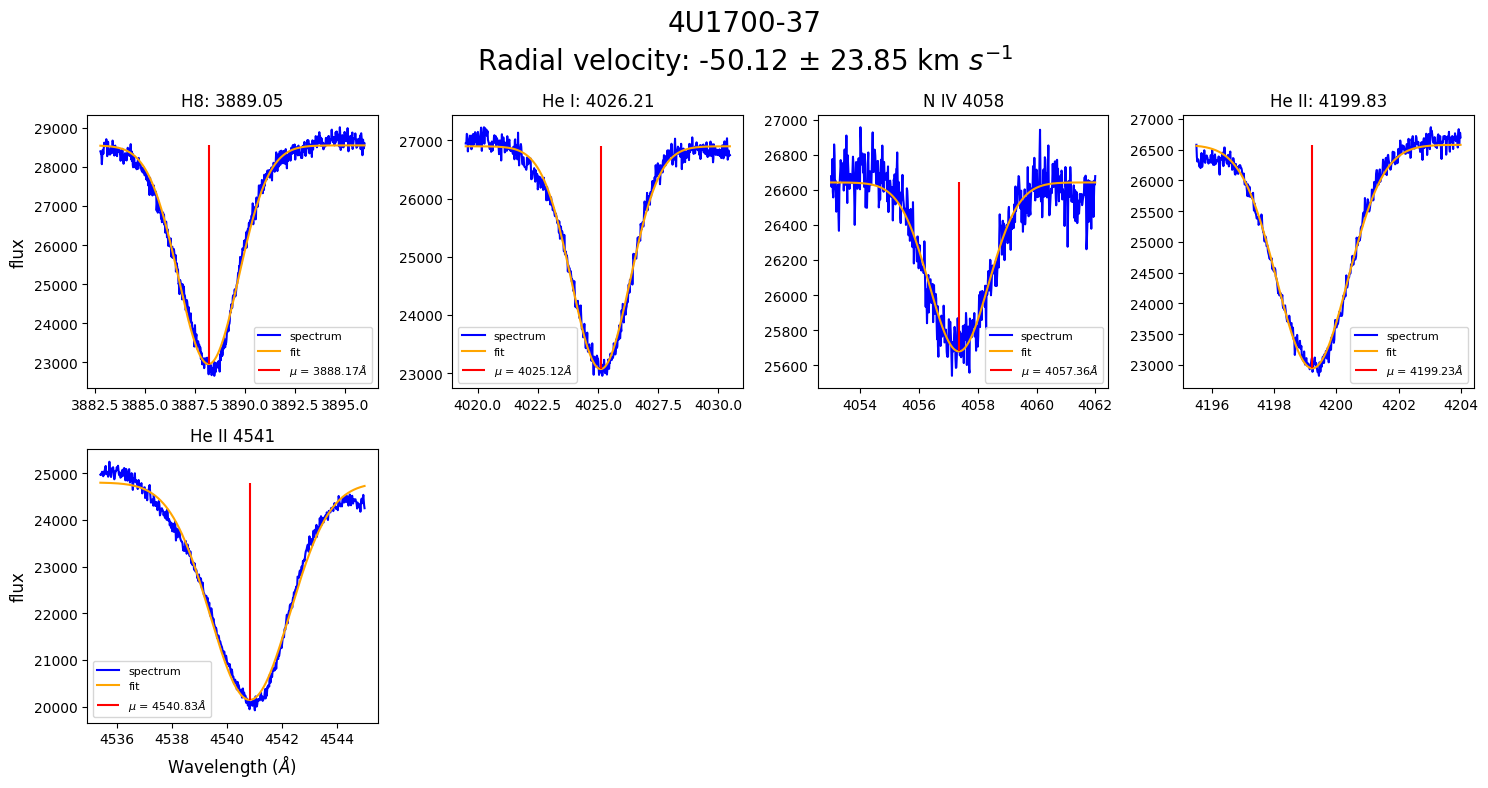

23.853733232522497


In [13]:
doppler_shifts = determine_doppler_shift(spectra, spectral_lines, gaussian, True)
print(np.std(doppler_shifts))

##### Calculate $\chi^{2}$ for all lines and all models.

In [14]:
chi2, chi2_perline = chi_squared_for_all_models2(spectra, models, spectral_lines, SNR=SNR, vrad=np.mean(doppler_shifts), vsini=vsini_best)

Iteration T56000logg4.2DONE

##### Plot the best model over the spectrum

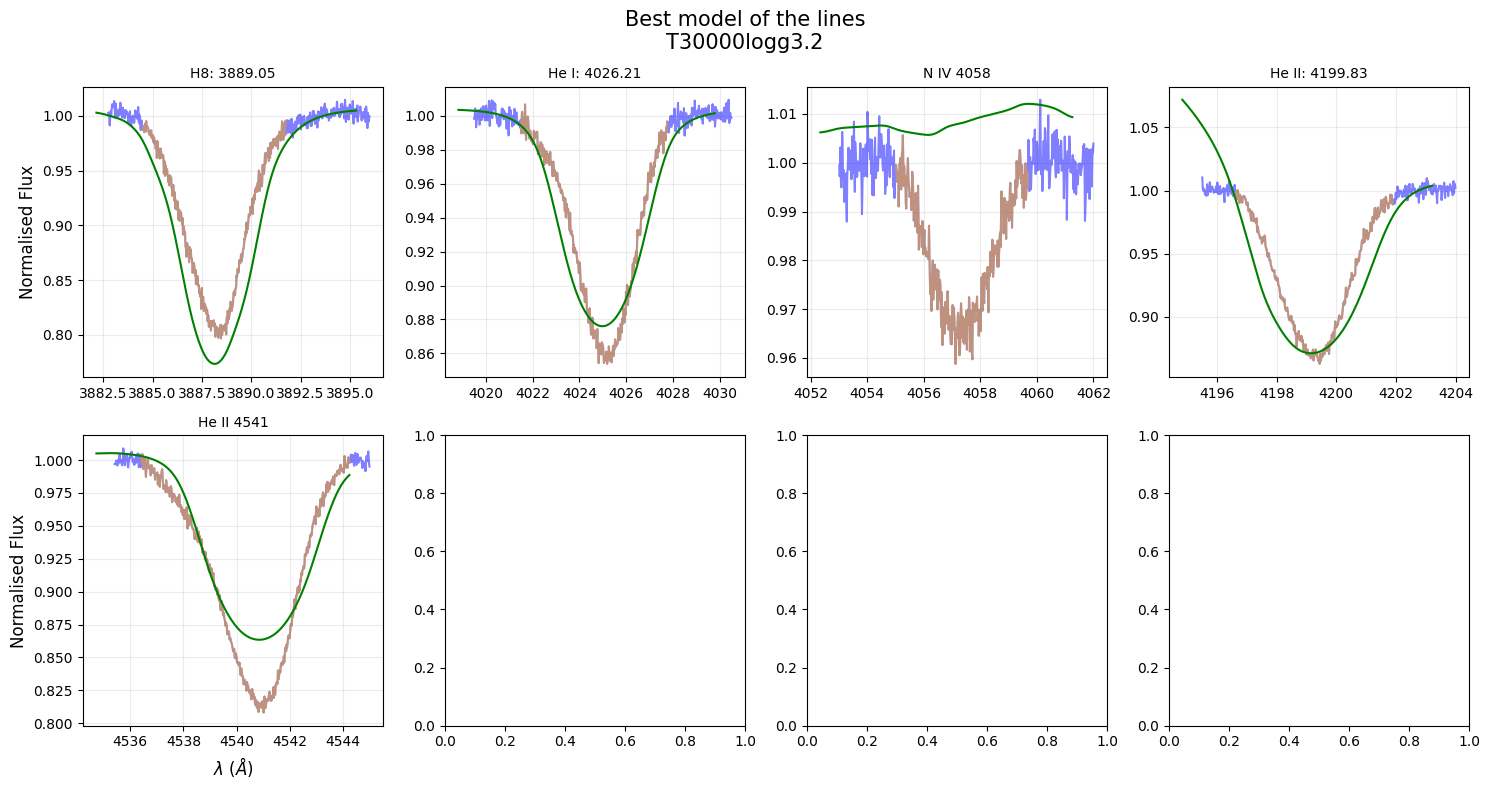

In [15]:
plot_best_model(spectra, models, spectral_lines, min(chi2, key=chi2.get), np.mean(doppler_shifts), vsini=vsini_best)

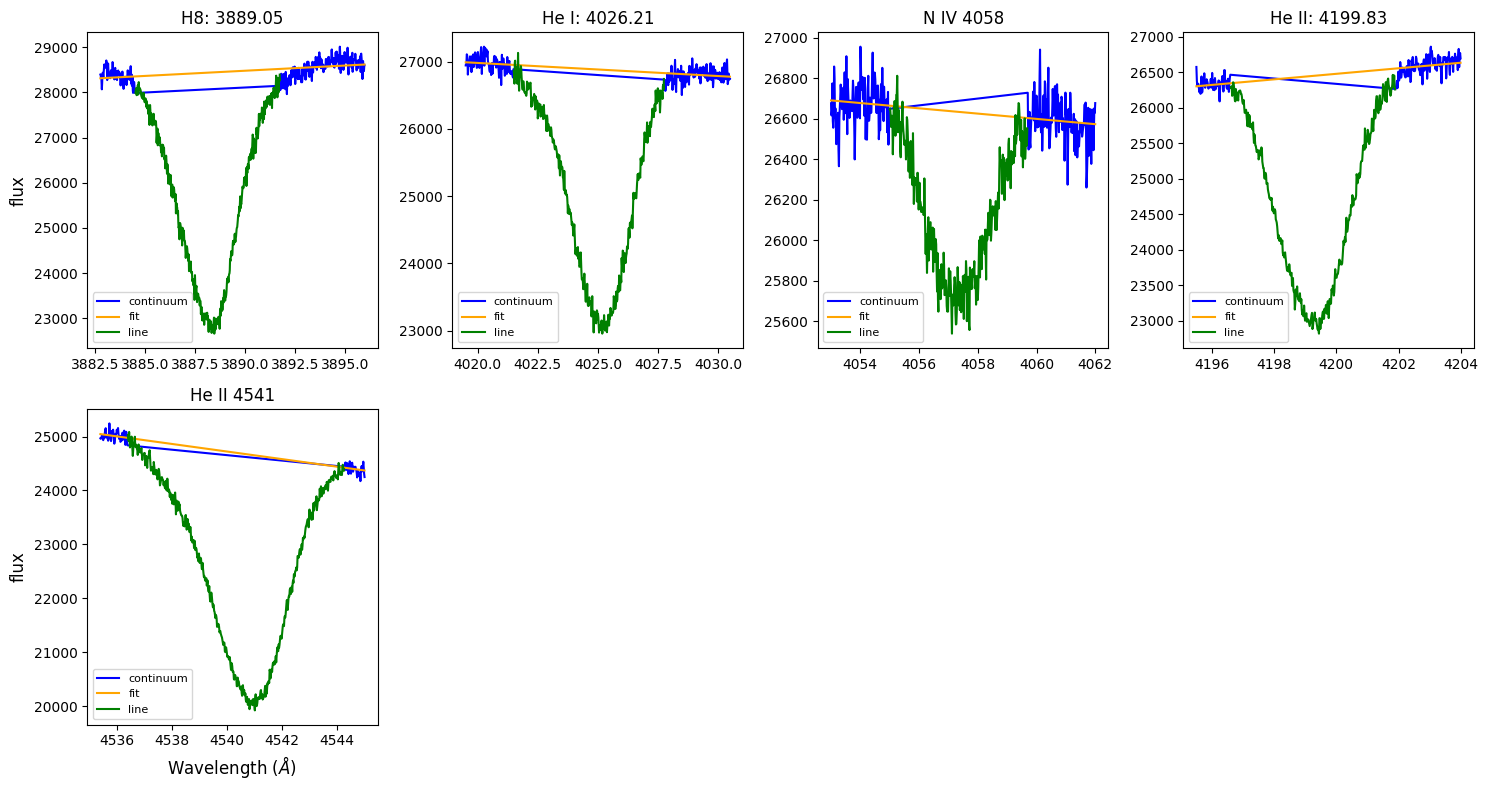

In [16]:
plot_continuum_fits(spectra, spectral_lines)

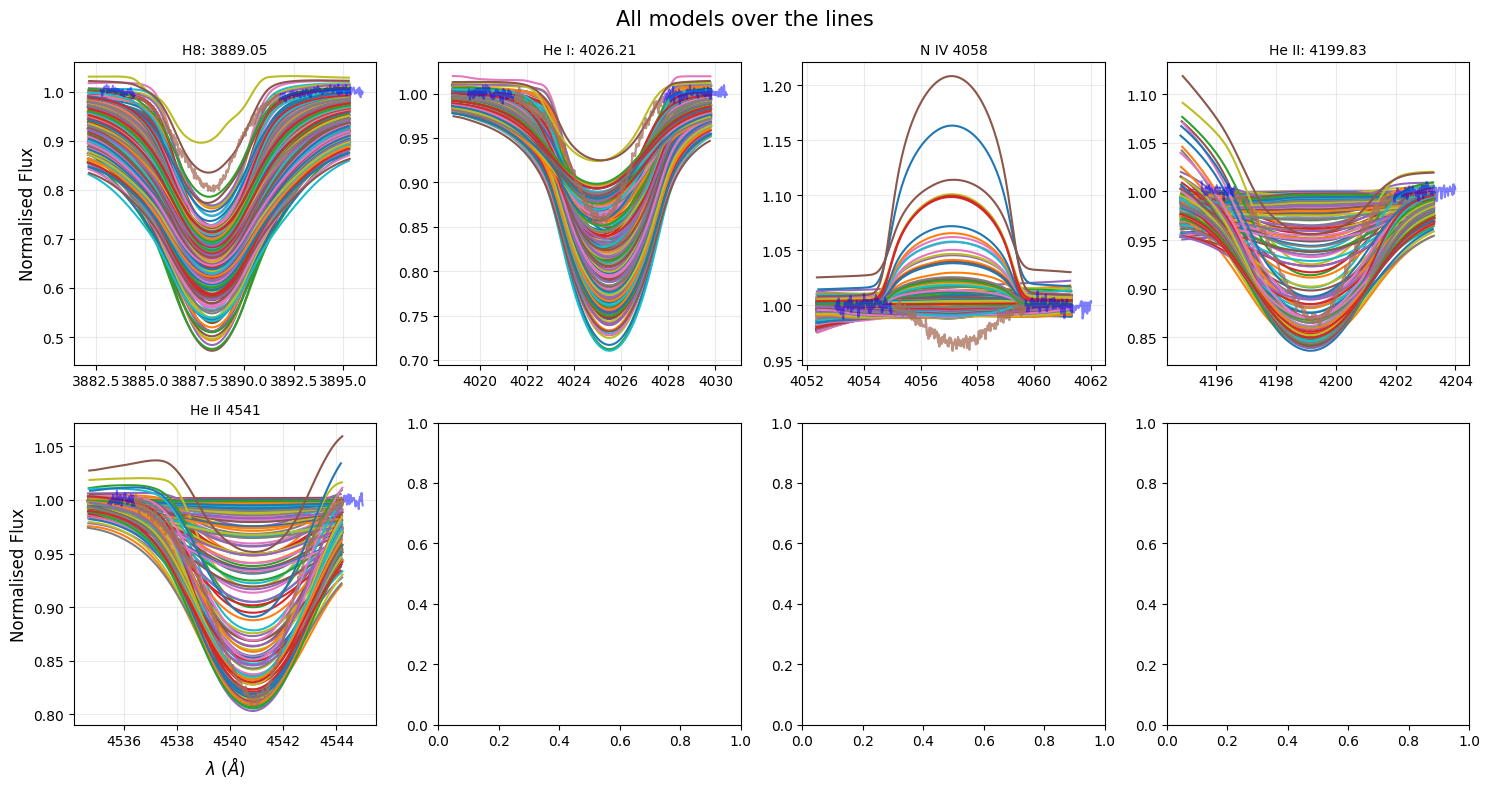

In [17]:
# plot_models_over_lines(spectra, models_in_interval(models, T1=10000, T2=30000, log_g1=2, log_g2=3), spectral_lines, vrad=np.mean(doppler_shifts), vsini=vsini_best)
plot_models_over_lines(spectra, models, spectral_lines, vrad=np.mean(doppler_shifts), vsini=vsini_best)